In [6]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torch.optim import SGD

import numpy as np
from numpy import dot
import matplotlib.pyplot as plt

In [7]:
input_size = 784
hidden_size = 2048
num_classes = 10
num_epochs = 50
batch_size = 50
learning_rate = 0.1

M_train = 1000
M_test = 200

In [8]:
# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='StandardData', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='StandardData', 
                                          train=False, 
                                          transform=transforms.ToTensor())

reduced_train_index=list(range(M_train))
reduced_test_index=list(range(M_test))

subset_train_dataset=Subset(train_dataset, reduced_train_index)
subset_test_dataset=Subset(test_dataset, reduced_test_index)

# Data loader
train_loader = DataLoader(dataset=subset_train_dataset, batch_size=batch_size, shuffle=True)

test_loader = DataLoader(dataset=subset_test_dataset, batch_size=batch_size, shuffle=False) 

In [9]:
# Fully connected neural network
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size) 
        self.output_layer = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        x = self.input_layer(x)
        x = x.relu()
        x = self.output_layer(x)
        return x
    
def ReLU_glorot_init(model):
    for name, param in model.named_parameters():
        
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            nn.init.xavier_normal_(param)

In [10]:
# Train the model

model_RealData = NeuralNet(input_size, hidden_size, num_classes)
ReLU_glorot_init(model_RealData)

criterion = nn.CrossEntropyLoss()
optimizer = SGD(model_RealData.parameters(), lr=learning_rate)

def train_epoch():

    no_parameters=input_size*hidden_size+hidden_size+hidden_size*num_classes+num_classes
    expected_gradient=np.zeros(no_parameters)
    expected_dot=0
    counter=0

    for images, labels in train_loader:
        images = images.reshape(-1, 28*28)
        outputs = model_RealData(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_gradient=[]
        batch_gradient+=torch.flatten(model_RealData.input_layer.weight.grad).tolist()
        batch_gradient+=model_RealData.input_layer.bias.grad.tolist()
        batch_gradient+=torch.flatten(model_RealData.output_layer.weight.grad).tolist()
        batch_gradient+=model_RealData.output_layer.bias.grad.tolist()
        batch_gradient=np.array(batch_gradient)
        expected_gradient+=batch_gradient
        expected_dot+=dot(batch_gradient,batch_gradient)
        counter+=1

        
    expected_dot=expected_dot/counter
    expected_gradient=expected_gradient/counter

    batchwise_coherence=dot(expected_gradient,expected_gradient)/expected_dot
    k=len(train_loader)
    perexample_coherence=batchwise_coherence/(k-(k-1)*batchwise_coherence)
    return loss.item(), perexample_coherence*M_train

def accuracy(loader):
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loader:
            images = images.reshape(-1, 28*28)
            outputs = model_RealData(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        return correct/total

def loss(loader):
    with torch.no_grad():
        loss = 0
        total = 0
        for images, labels in loader:
            images = images.reshape(-1, 28*28)
            outputs = model_RealData(images)
            loss += criterion(outputs, labels).item()*labels.size(0)
            total += labels.size(0)
        return loss/total

train_loss=[]
train_accuracy=[]
test_loss=[]
test_accuracy=[]
epoch_list=[]
alpha_list=[]

for epoch in range(num_epochs):
    trainloss, alpha = train_epoch()
    train_loss.append(trainloss)
    alpha_list.append(alpha)
    train_accuracy.append(accuracy(train_loader))
    test_loss.append(loss(test_loader))
    test_accuracy.append(accuracy(test_loader))
    epoch_list.append(epoch)
    print('Epoch: {} TrainLoss: {:.3f} TestLoss: {:.3f} TrainAccuracy: {:.3f} TestAccuracy: {:.3f} Coherence: {:.3f}'.format(epoch+1,train_loss[-1],test_loss[-1],train_accuracy[-1],test_accuracy[-1],alpha_list[-1]))

Epoch: 1 TrainLoss: 1.040 TestLoss: 1.045 TrainAccuracy: 0.835 TestAccuracy: 0.750 Coherence: 12.680
Epoch: 2 TrainLoss: 0.685 TestLoss: 0.719 TrainAccuracy: 0.881 TestAccuracy: 0.830 Coherence: 5.179
Epoch: 3 TrainLoss: 0.464 TestLoss: 0.590 TrainAccuracy: 0.901 TestAccuracy: 0.850 Coherence: 2.677
Epoch: 4 TrainLoss: 0.251 TestLoss: 0.508 TrainAccuracy: 0.920 TestAccuracy: 0.875 Coherence: 2.210
Epoch: 5 TrainLoss: 0.501 TestLoss: 0.467 TrainAccuracy: 0.931 TestAccuracy: 0.905 Coherence: 1.695
Epoch: 6 TrainLoss: 0.352 TestLoss: 0.440 TrainAccuracy: 0.941 TestAccuracy: 0.880 Coherence: 1.613
Epoch: 7 TrainLoss: 0.277 TestLoss: 0.410 TrainAccuracy: 0.943 TestAccuracy: 0.880 Coherence: 1.335
Epoch: 8 TrainLoss: 0.154 TestLoss: 0.384 TrainAccuracy: 0.954 TestAccuracy: 0.905 Coherence: 1.344
Epoch: 9 TrainLoss: 0.254 TestLoss: 0.355 TrainAccuracy: 0.958 TestAccuracy: 0.905 Coherence: 1.265
Epoch: 10 TrainLoss: 0.212 TestLoss: 0.336 TrainAccuracy: 0.964 TestAccuracy: 0.905 Coherence: 1.12

Text(0.5, 1.0, 'Coherence Against Loss')

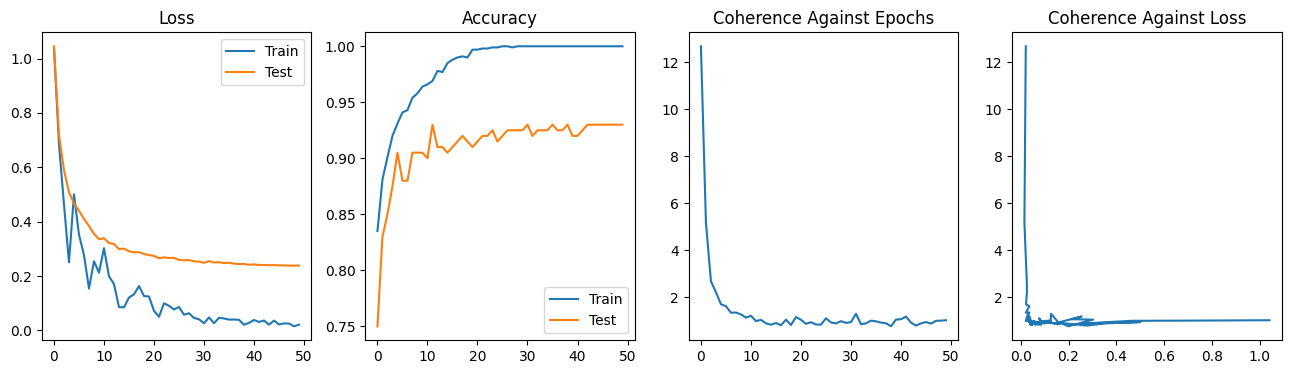

In [18]:
fig, axs = plt.subplots(1,4)

fig.set_size_inches(16,4)

axs[0].plot(np.arange(num_epochs), train_loss,label='Train')
axs[0].plot(np.arange(num_epochs), test_loss,label='Test')
axs[0].set_title('Loss')
axs[0].legend()
axs[1].plot(np.arange(num_epochs), train_accuracy,label='Train')
axs[1].plot(np.arange(num_epochs), test_accuracy,label='Test')
axs[1].set_title('Accuracy')
axs[1].legend()
axs[2].plot(np.arange(num_epochs), alpha_list)
axs[2].set_title('Coherence Against Epochs')
axs[3].plot(np.flip(train_loss), alpha_list)
axs[3].set_title('Coherence Against Loss')

In [12]:
batch_size = 25

In [13]:
# MNIST dataset 
random_train_dataset = torchvision.datasets.MNIST(root='ShuffledData', 
                                           train=True, 
                                           transform=transforms.ToTensor(), 
                                           target_transform=lambda y: torch.randint(0, 4, (1,)).item() if y<=4 else y, 
                                           download=True)

random_test_dataset = torchvision.datasets.MNIST(root='ShuffledData', 
                                          train=False, 
                                          transform=transforms.ToTensor(),
                                          target_transform=lambda y: torch.randint(0, 4, (1,)).item() if y<=4 else y)

reduced_train_index=list(range(M_train))
reduced_test_index=list(range(M_test))

subset_random_train_dataset=Subset(random_train_dataset, reduced_train_index)
subset_random_test_dataset=Subset(random_test_dataset, reduced_test_index)

# Data loader
random_train_loader = DataLoader(dataset=subset_random_train_dataset, batch_size=batch_size, shuffle=True)

random_test_loader = DataLoader(dataset=subset_random_test_dataset, batch_size=batch_size, shuffle=False) 

In [14]:
model_RandomData = NeuralNet(input_size, hidden_size, num_classes)
ReLU_glorot_init(model_RandomData)

criterion = nn.CrossEntropyLoss()
optimizer = SGD(model_RandomData.parameters(), lr=learning_rate) 

def r_train_epoch():

    no_parameters=input_size*hidden_size+hidden_size+hidden_size*num_classes+num_classes
    expected_gradient=np.zeros(no_parameters)
    expected_dot=0
    counter=0

    for images, labels in random_train_loader:
        images = images.reshape(-1, 28*28)
        outputs = model_RandomData(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_gradient=[]
        batch_gradient+=torch.flatten(model_RandomData.input_layer.weight.grad).tolist()
        batch_gradient+=model_RandomData.input_layer.bias.grad.tolist()
        batch_gradient+=torch.flatten(model_RandomData.output_layer.weight.grad).tolist()
        batch_gradient+=model_RandomData.output_layer.bias.grad.tolist()
        batch_gradient=np.array(batch_gradient)
        expected_gradient+=batch_gradient
        expected_dot+=dot(batch_gradient,batch_gradient)
        counter+=1
    expected_dot=expected_dot/counter
    expected_gradient=expected_gradient/counter

    batchwise_coherence=dot(expected_gradient,expected_gradient)/expected_dot
    k=len(random_train_loader)
    perexample_coherence=batchwise_coherence/(k-(k-1)*batchwise_coherence)
    return loss.item(), perexample_coherence*M_train

def r_accuracy(loader):
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loader:
            images = images.reshape(-1, 28*28)
            labels = labels
            outputs = model_RandomData(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        return correct/total

def r_loss(loader):
    with torch.no_grad():
        loss = 0
        total = 0
        for images, labels in loader:
            images = images.reshape(-1, 28*28)
            labels = labels
            outputs = model_RandomData(images)
            loss += criterion(outputs, labels).item()*labels.size(0)
            total += labels.size(0)
        return loss/total

random_train_loss=[]
random_train_accuracy=[]
random_test_loss=[]
random_test_accuracy=[]
random_alpha_list=[]

for epoch in range(num_epochs):
    random_trainloss, random_alpha = r_train_epoch()
    random_train_loss.append(random_trainloss)
    random_alpha_list.append(random_alpha)
    random_train_accuracy.append(r_accuracy(random_train_loader))
    random_test_loss.append(r_loss(random_test_loader))
    random_test_accuracy.append(r_accuracy(random_test_loader))
    print('Epoch: {} TrainLoss: {:.3f} TestLoss: {:.3f} TrainAccuracy: {:.3f} TestAccuracy: {:.3f} Coherence: {:.3f}'.format(epoch+1,random_train_loss[-1],random_test_loss[-1],random_train_accuracy[-1],random_test_accuracy[-1],random_alpha_list[-1]))

Epoch: 1 TrainLoss: 1.253 TestLoss: 1.506 TrainAccuracy: 0.517 TestAccuracy: 0.450 Coherence: 1.102
Epoch: 2 TrainLoss: 1.161 TestLoss: 1.359 TrainAccuracy: 0.545 TestAccuracy: 0.510 Coherence: 0.375
Epoch: 3 TrainLoss: 1.166 TestLoss: 1.343 TrainAccuracy: 0.548 TestAccuracy: 0.505 Coherence: 0.323
Epoch: 4 TrainLoss: 1.078 TestLoss: 1.192 TrainAccuracy: 0.579 TestAccuracy: 0.525 Coherence: 0.323
Epoch: 5 TrainLoss: 0.851 TestLoss: 1.144 TrainAccuracy: 0.584 TestAccuracy: 0.525 Coherence: 0.265
Epoch: 6 TrainLoss: 0.807 TestLoss: 1.171 TrainAccuracy: 0.584 TestAccuracy: 0.510 Coherence: 0.251
Epoch: 7 TrainLoss: 1.069 TestLoss: 1.109 TrainAccuracy: 0.615 TestAccuracy: 0.535 Coherence: 0.244
Epoch: 8 TrainLoss: 0.816 TestLoss: 1.105 TrainAccuracy: 0.584 TestAccuracy: 0.540 Coherence: 0.260
Epoch: 9 TrainLoss: 0.501 TestLoss: 1.110 TrainAccuracy: 0.598 TestAccuracy: 0.540 Coherence: 0.288
Epoch: 10 TrainLoss: 1.068 TestLoss: 1.097 TrainAccuracy: 0.594 TestAccuracy: 0.535 Coherence: 0.305

Text(0.5, 1.0, 'Coherence Against Loss')

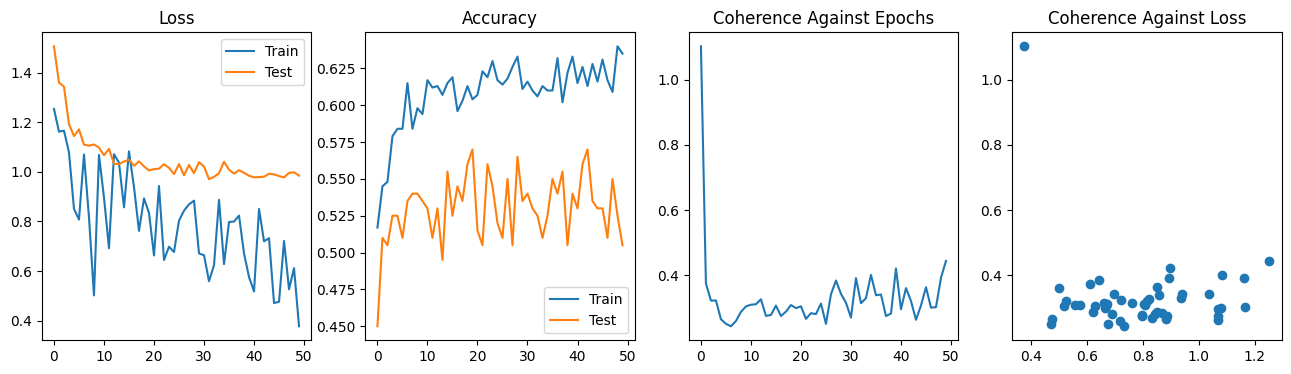

In [17]:
fig, axs = plt.subplots(1,4)

fig.set_size_inches(16,4)

axs[0].plot(np.arange(num_epochs), random_train_loss,label='Train')
axs[0].plot(np.arange(num_epochs), random_test_loss,label='Test')
axs[0].set_title('Loss')
axs[0].legend()
axs[1].plot(np.arange(num_epochs), random_train_accuracy,label='Train')
axs[1].plot(np.arange(num_epochs), random_test_accuracy,label='Test')
axs[1].set_title('Accuracy')
axs[1].legend()
axs[2].plot(np.arange(num_epochs), random_alpha_list)
axs[2].set_title('Coherence Against Epochs')
axs[3].scatter(np.flip(random_train_loss), random_alpha_list)
axs[3].set_title('Coherence Against Loss')

Here approximately $50$% of the data is clean and the rest is randomized. Hence, we see that accuracy is much lower than the clean case.